<xarray.Dataset> Size: 3MB
Dimensions:    (y: 292, x: 362)
Dimensions without coordinates: y, x
Data variables:
    atlmsk     (y, x) float32 423kB ...
    glomsk     (y, x) float32 423kB ...
    indmsk     (y, x) float32 423kB ...
    indpacmsk  (y, x) float32 423kB ...
    nav_lat    (y, x) float32 423kB ...
    nav_lon    (y, x) float32 423kB ...
    pacmsk     (y, x) float32 423kB ...
Attributes:
    ece-comment:  Based on SHACONEMO INPUTS_ORCA1_LIM3_PISCES_V9/eORCA_R1_sub...
    ece-origin:   UFla (SMHI) for EC-Earth
Coordinates:
    *empty*
Variables in the mask dataset: ['atlmsk', 'glomsk', 'indmsk', 'indpacmsk', 'nav_lat', 'nav_lon', 'pacmsk']
<xarray.DataArray 'atlmsk' (y: 292, x: 362)> Size: 423kB
[105704 values with dtype=float32]
Dimensions without coordinates: y, x
Attributes:
    long_name:  atlantic ocean without med sea


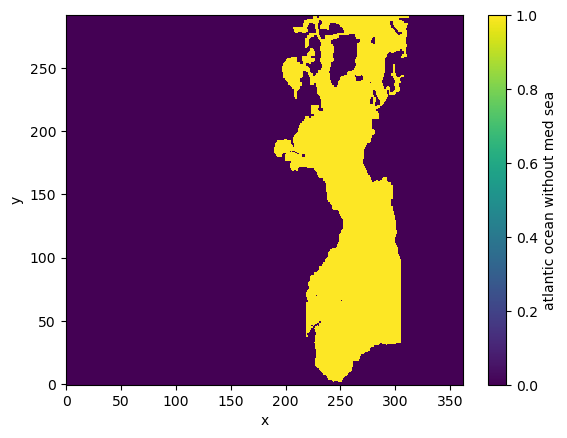

In [ ]:
import xarray as xr

# -----------------------------
# 1. Load the mask
# -----------------------------
mask_file = "/data/users/mde/FREJA/subbasins.nc"
mask_ds = xr.open_dataset(mask_file)

# -----------------------------
# 2. Inspect the dataset
# -----------------------------
print(mask_ds)  # prints dimensions, coordinates, and data variables
print(mask_ds.coords)  # prints coordinate variables

# -----------------------------
# 3. List the variables
# -----------------------------
print("Variables in the mask dataset:", list(mask_ds.data_vars))

# -----------------------------
# 4. View one of the variables (for example, the first one)
# -----------------------------
first_var_name = list(mask_ds.data_vars)[0]
mask_data = mask_ds[first_var_name]
print(mask_data)  # prints the DataArray with values and coordinates

# -----------------------------
# 5. Optional: quick plot to see the mask
# -----------------------------
mask_data.plot()




In [4]:
import xarray as xr
import numpy as np
# 1. Load the mask (auto-detect variable and align to thetao grid)
# -----------------------------
mask_file = "/data/users/mde/FREJA/subbasins.nc"
mask_ds = xr.open_dataset(mask_file)

# load thetao to get its grid
thetao_file = "/data/projects/nckf/frekle/CMIP6_data/thetao/thetao_Oyear_EC-Earth3_historical_r1i1p1f1_gn_185001-201412.nc"
thetao = xr.open_dataset(thetao_file)['thetao']

# Auto-detect a mask variable that has lat/lon dims; fall back to the first data var
mask_vars = list(mask_ds.data_vars)
candidates = [v for v in mask_vars if (any(k in mask_ds[v].dims for k in ['latitude','lat','y','j']) and any(k in mask_ds[v].dims for k in ['longitude','lon','x','i']))]
mask_var = candidates[0] if candidates else mask_vars[0]
print("Using mask variable:", mask_var)
mask = mask_ds[mask_var].squeeze()

# -----------------------------
# 2. Align/interpolate mask to the thetao horizontal grid (nearest neighbour)
# -----------------------------
thetao_grid = thetao.isel(time=0).drop_vars([v for v in thetao.coords if v == 'time' or v == 'lev']) if 'time' in thetao.coords else thetao.isel(time=0)
# Ensure mask and thetao_grid have compatible dimensions for interpolation
if 'latitude' in mask.coords and 'longitude' in mask.coords:
    mask_on_grid = mask.interp(latitude=thetao_grid['latitude'], longitude=thetao_grid['longitude'], method='nearest')
elif 'lat' in mask.coords and 'lon' in mask.coords:
    mask_on_grid = mask.interp(lat=thetao_grid['lat'], lon=thetao_grid['lon'], method='nearest')
elif 'nav_lat' in mask_ds.data_vars and 'nav_lon' in mask_ds.data_vars:
    # Use nav_lat and nav_lon from mask_ds for interpolation
    mask_on_grid = mask.interp(
        y=thetao_grid['j'], x=thetao_grid['i'],
        kwargs={"fill_value": None},
        method='nearest'
    )
else:
    raise ValueError("Mask does not have recognizable latitude/longitude coordinates for interpolation.")

# Build a boolean mask (True inside the region). Treat non-zero & finite as inside.
mask_bool = (np.isfinite(mask_on_grid)) & (mask_on_grid != 0)

# save the mask for future reference
# mask_bool.to_netcdf("mask_bool2.nc")

# Print mask info
print(mask_bool)

Using mask variable: atlmsk
<xarray.DataArray 'atlmsk' (j: 292, i: 362)> Size: 106kB
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], shape=(292, 362))
Coordinates:
    y        (j) int32 1kB 1 2 3 4 5 6 7 8 9 ... 285 286 287 288 289 290 291 292
    x        (i) int32 1kB 1 2 3 4 5 6 7 8 9 ... 355 356 357 358 359 360 361 362
  * j        (j) int32 1kB 1 2 3 4 5 6 7 8 9 ... 285 286 287 288 289 290 291 292
  * i        (i) int32 1kB 1 2 3 4 5 6 7 8 9 ... 355 356 357 358 359 360 361 362


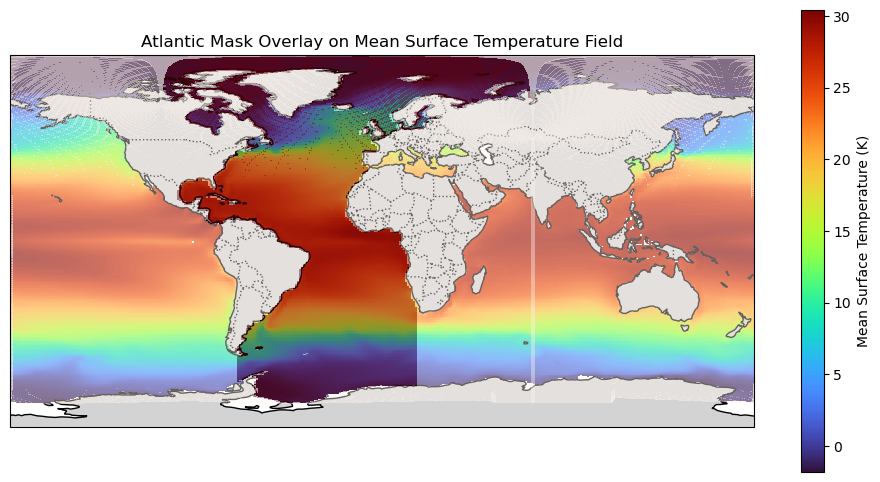

In [11]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# -----------------------------
# 1. Load datasets
# -----------------------------
thetao_file = "/data/projects/nckf/frekle/CMIP6_data/thetao/thetao_Oyear_EC-Earth3_historical_r1i1p1f1_gn_185001-201412.nc"
mask_file = "/data/users/frekle/mask_bool2.nc"

thetao_ds = xr.open_dataset(thetao_file)
mask_ds = xr.open_dataset(mask_file)

# Extract top layer mean for background
thetao_surf_mean = thetao_ds["thetao"].isel(lev=0).mean(dim="time")

# Extract mask
mask = mask_ds["atlmsk"]

# Get latitude and longitude from thetao dataset
lat = thetao_ds['latitude']
lon = thetao_ds['longitude']

# -----------------------------
# 2. Plot
# -----------------------------
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add coastlines and land
ax.coastlines()
ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder=0)
ax.add_feature(cfeature.BORDERS, linestyle=':', zorder=0)
ax.set_global()

# Plot thetao mean as background
pcm = ax.pcolormesh(
    lon, lat, thetao_surf_mean,
    transform=ccrs.PlateCarree(),
    cmap='turbo',
    shading='auto'
)
fig.colorbar(pcm, ax=ax, orientation='vertical', label='Mean Surface Temperature (K)')

# Plot mask overlay using thetao lat/lon
ax.pcolormesh(
    lon,
    lat,
    mask,
    transform=ccrs.PlateCarree(),
    cmap='Reds',
    alpha=0.4,
    zorder=2
)

plt.title("Atlantic Mask Overlay on Mean Surface Temperature Field")
plt.show()


In [12]:
import xarray as xr

# --- File paths ---
thetao_path = "/data/projects/nckf/frekle/CMIP6_data/thetao/thetao_Oyear_EC-Earth3_historical_r1i1p1f1_gn_185001-201412.nc"
so_path = "/data/projects/nckf/frekle/CMIP6_data/so/so_Oyear_EC-Earth3_historical_r1i1p1f1_gn_185001-201412.nc"
mask_path = "/data/users/frekle/mask_bool2.nc"

# --- Output paths ---
thetao_masked_out = "/data/projects/nckf/frekle/CMIP6_data/thetao/thetao_masked.nc"
so_masked_out = "/data/projects/nckf/frekle/CMIP6_data/so/so_masked.nc"

# --- Load datasets ---
ds_thetao = xr.open_dataset(thetao_path)
ds_so = xr.open_dataset(so_path)
ds_mask = xr.open_dataset(mask_path)

# --- Load mask variable (assume it's named 'atlmsk') ---
mask = ds_mask["atlmsk"]

# --- Ensure mask is boolean ---
mask = mask.astype(bool)
 
# --- Apply mask to all depth levels (3D mask) ---
thetao = ds_thetao["thetao"]
so = ds_so["so"]

# Expand mask along the vertical (lev) dimension
mask_3d = mask.broadcast_like(thetao)

# Apply mask
thetao_masked = thetao.where(mask_3d)
so_masked = so.where(mask_3d)

# --- Save masked data ---
thetao_masked.to_dataset(name="thetao").to_netcdf(thetao_masked_out)
so_masked.to_dataset(name="so").to_netcdf(so_masked_out)

print("✅ 3D masked files saved successfully:")
print(f"- {thetao_masked_out}")
print(f"- {so_masked_out}")


✅ 3D masked files saved successfully:
- /data/projects/nckf/frekle/CMIP6_data/thetao/thetao_masked.nc
- /data/projects/nckf/frekle/CMIP6_data/so/so_masked.nc


In [9]:
# Mask for mlotst and msfytz

# --- File paths ---
mlotst_path = "/data/projects/nckf/frekle/CMIP6_data/mlotst/mlotst_Oyear_EC-Earth3_historical_r1i1p1f1_gn_185001-201412.nc"
msftyz_path = "/data/projects/nckf/frekle/CMIP6_data/msftyz/msftyz_Oyear_EC-Earth3_historical_r1i1p1f1_gn_185001-201412.nc"
mask_path = "/data/users/frekle/mask_bool2.nc"

# --- Output paths ---
mlotst_masked_out = "/data/projects/nckf/frekle/CMIP6_data/mlotst/mlotst_masked.nc"
msftyz_masked_out = "/data/projects/nckf/frekle/CMIP6_data/msftyz/msftyz_masked.nc"

# --- Load datasets ---
ds_mlotst = xr.open_dataset(mlotst_path)
ds_msftyz = xr.open_dataset(msftyz_path)
ds_mask = xr.open_dataset(mask_path)

# --- Load mask variable (assume it's named 'atlmsk') ---
mask = ds_mask["atlmsk"]

# --- Ensure mask is boolean ---
mask = mask.astype(bool)
 
# --- Apply mask to all depth levels (3D mask) ---
mlotst = ds_mlotst["mlotst"]
msftyz = ds_msftyz["msftyz"]

# Expand mask along the vertical (lev) dimension
mask_3d_mlotst = mask.broadcast_like(mlotst)
mask_3d_msftyz = mask.broadcast_like(msftyz)

# Apply mask
mlotst_masked = mlotst.where(mask_3d_mlotst)
#msftyz_masked = msftyz.where(mask_3d_msftyz)

# --- Save masked data ---
mlotst_masked.to_dataset(name="mlotst").to_netcdf(mlotst_masked_out)
# msftyz_masked.to_dataset(name="msftyz").to_netcdf(msftyz_masked_out)

print("✅ 3D masked files saved successfully:")
print(f"- {mlotst_masked_out}")
# print(f"- {msftyz_masked_out}")


✅ 3D masked files saved successfully:
- /data/projects/nckf/frekle/CMIP6_data/mlotst/mlotst_masked.nc


### Loop through all members

🧪 Testing mask overlay on: r10i1p1f1
✅ Mask dims: ('j', 'i'), dtype: bool

✅ Masking applied in memory.
Original dims: (165, 75, 292, 362)
Masked dims:   (165, 75, 292, 362)


/dmidata/users/frekle/miniforge3/envs/aimoc_env/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:512: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  super()._update_title_position(renderer)
/dmidata/users/frekle/miniforge3/envs/aimoc_env/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:512: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  super()._update_title_position(renderer)
/dmidata/users/frekle/miniforge3/envs/aimoc_env/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:509: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  return super().draw(renderer=renderer, **kwargs)


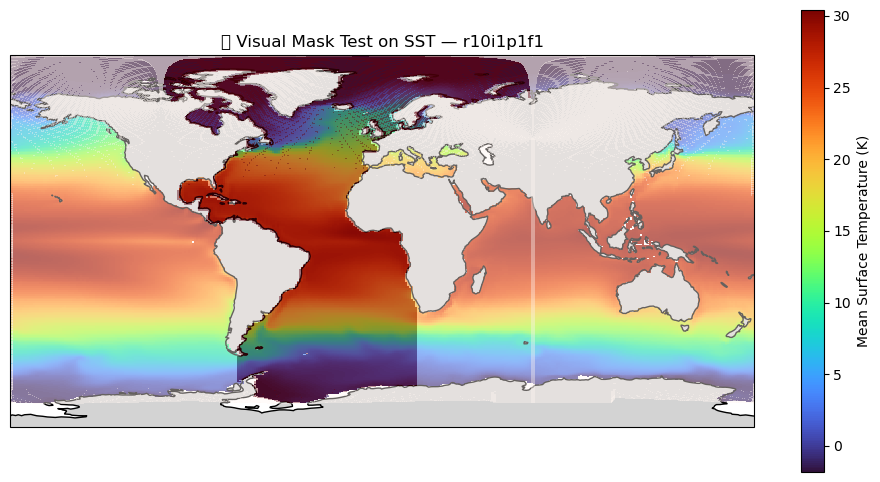


🎉 Test completed. No files were saved — this was only a visual check.


In [6]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from glob import glob

# --- Test setup ---
src_base = "/dmidata/projects/nckf/cmip6/historical/EC-Earth3"
mask_path = "/data/users/frekle/mask_bool2.nc"

member_path = sorted(glob(f"{src_base}/r*i1p1f1"))[0]  # just first member
member = member_path.split("/")[-1]
print(f"🧪 Testing mask overlay on: {member}")

# --- Load mask ---
mask = xr.open_dataset(mask_path)["atlmsk"].astype(bool).reset_coords(drop=True)
print(f"✅ Mask dims: {mask.dims}, dtype: {mask.dtype}")

# --- Load thetao (SST) for plotting ---
thetao_src = glob(f"{member_path}/Oyear/thetao/thetao_*.nc")[0]
ds_thetao = xr.open_dataset(thetao_src)  # no chunks = fast for plotting
thetao_surf_mean = ds_thetao["thetao"].isel(lev=0).mean(dim="time")

# Get lat/lon for map
lat = ds_thetao["latitude"]
lon = ds_thetao["longitude"]

# --- Apply mask (not saving, just show result) ---
thetao_masked = ds_thetao["thetao"].where(mask)

print("\n✅ Masking applied in memory.")
print(f"Original dims: {ds_thetao['thetao'].shape}")
print(f"Masked dims:   {thetao_masked.shape}")

# --- PLOT ---
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.coastlines()
ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder=0)
ax.set_global()

# Background SST
pcm = ax.pcolormesh(
    lon, lat, thetao_surf_mean,
    transform=ccrs.PlateCarree(),
    cmap="turbo",
    shading="auto"
)
fig.colorbar(pcm, ax=ax, orientation='vertical', label='Mean Surface Temperature (K)')

# Mask overlay
ax.pcolormesh(
    lon,
    lat,
    mask,
    transform=ccrs.PlateCarree(),
    cmap='Reds',
    alpha=0.4,
    zorder=2
)

plt.title(f"✅ Visual Mask Test on SST — {member}")
plt.show()

print("\n🎉 Test completed. No files were saved — this was only a visual check.")



In [1]:
import os
from glob import glob
import xarray as xr

# ------------ Paths ------------
src_base = "/dmidata/projects/nckf/cmip6/historical/EC-Earth3"
dst_base = "/data/projects/nckf/frekle/CMIP6_data"
mask_path = "/data/users/frekle/mask_bool2.nc"  # dims: (j, i), var: atlmsk

# Ensure output folders exist
os.makedirs(f"{dst_base}/thetao", exist_ok=True)
os.makedirs(f"{dst_base}/so", exist_ok=True)

# ------------ Load mask once ------------
ds_mask = xr.open_dataset(mask_path)
mask = ds_mask["atlmsk"].astype(bool)  # (j, i)

# ------------ Find ensemble members ------------
members = sorted(glob(f"{src_base}/r*i1p1f1"))

if not members:
    raise RuntimeError("No ensemble member folders found under "
                       f"{src_base}/r*i1p1f1")

for member_path in members:
    member = os.path.basename(member_path)  # e.g., r1i1p1f1
    print(f"\n🔄 Processing {member} ...")

    # Locate input files (one per var)
    thetao_src_list = glob(f"{member_path}/Oyear/thetao/thetao_*.nc")
    so_src_list     = glob(f"{member_path}/Oyear/so/so_*.nc")

    if not thetao_src_list or not so_src_list:
        print(f"⚠️  Missing thetao/so input for {member} — skipping.")
        continue

    thetao_src = thetao_src_list[0]
    so_src     = so_src_list[0]

    # Open datasets (no compression/chunking; same approach as your single-member script)
    ds_thetao = xr.open_dataset(thetao_src)
    ds_so     = xr.open_dataset(so_src)

    thetao = ds_thetao["thetao"]  # (time, lev, j, i)
    so     = ds_so["so"]          # (time, lev, j, i)

    # --- 3D broadcast of mask (exactly as in your working example) ---
    mask_3d = mask.broadcast_like(thetao)  # expands to (time, lev, j, i)

    # Apply mask
    thetao_masked = thetao.where(mask_3d)
    so_masked     = so.where(mask_3d)

    # Output paths (overwrite if exists)
    thetao_out = f"{dst_base}/thetao/thetao_masked_{member}.nc"
    so_out     = f"{dst_base}/so/so_masked_{member}.nc"

    # Save (no compression)
    thetao_masked.to_dataset(name="thetao").to_netcdf(thetao_out)
    so_masked.to_dataset(name="so").to_netcdf(so_out)

    print(f"✅ Saved: {thetao_out}")
    print(f"✅ Saved: {so_out}")

print("\n🎉 All ensemble members processed (SST + SSS, 3D mask applied, no compression).")




🔄 Processing r10i1p1f1 ...
✅ Saved: /data/projects/nckf/frekle/CMIP6_data/thetao/thetao_masked_r10i1p1f1.nc
✅ Saved: /data/projects/nckf/frekle/CMIP6_data/so/so_masked_r10i1p1f1.nc

🔄 Processing r11i1p1f1 ...
✅ Saved: /data/projects/nckf/frekle/CMIP6_data/thetao/thetao_masked_r11i1p1f1.nc
✅ Saved: /data/projects/nckf/frekle/CMIP6_data/so/so_masked_r11i1p1f1.nc

🔄 Processing r12i1p1f1 ...
✅ Saved: /data/projects/nckf/frekle/CMIP6_data/thetao/thetao_masked_r12i1p1f1.nc
✅ Saved: /data/projects/nckf/frekle/CMIP6_data/so/so_masked_r12i1p1f1.nc

🔄 Processing r13i1p1f1 ...
✅ Saved: /data/projects/nckf/frekle/CMIP6_data/thetao/thetao_masked_r13i1p1f1.nc
✅ Saved: /data/projects/nckf/frekle/CMIP6_data/so/so_masked_r13i1p1f1.nc

🔄 Processing r14i1p1f1 ...
✅ Saved: /data/projects/nckf/frekle/CMIP6_data/thetao/thetao_masked_r14i1p1f1.nc
✅ Saved: /data/projects/nckf/frekle/CMIP6_data/so/so_masked_r14i1p1f1.nc

🔄 Processing r15i1p1f1 ...
✅ Saved: /data/projects/nckf/frekle/CMIP6_data/thetao/thetao_m